C:\Users\Nachu\AppData\Local\Temp\ipykernel_14432\2138085902.py:50: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["is_senior"] = df["title"].str.contains(senior_pattern, case=False, na=False).astype(int)


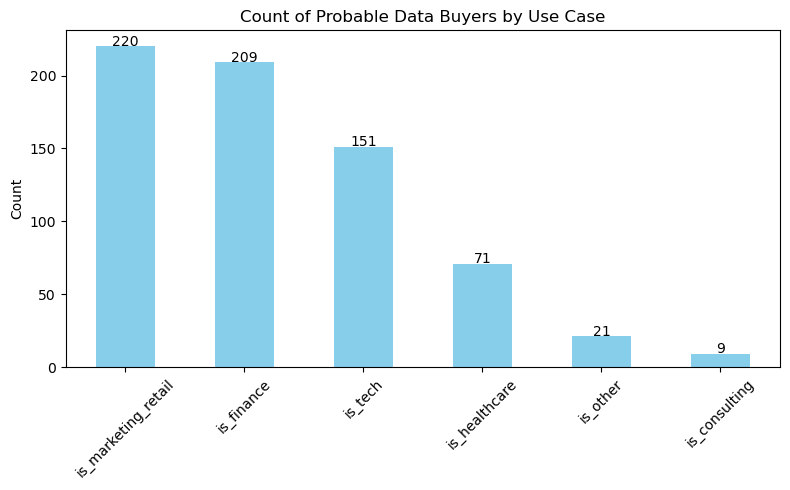

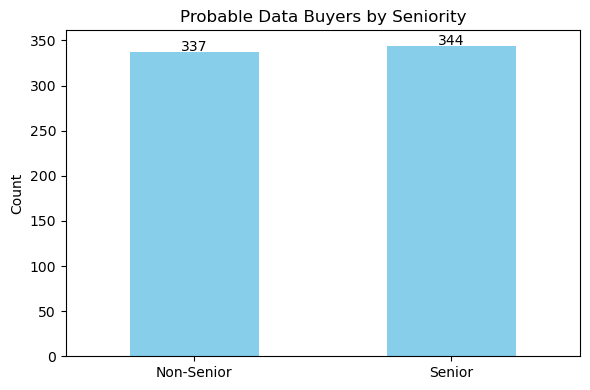

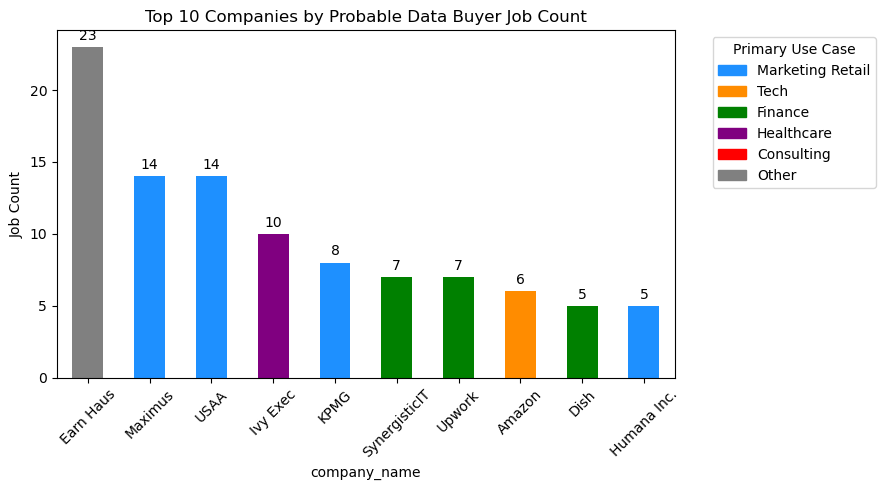

In [1]:
# Part 1: Load data, preprocessing, column engineering, and EDA

import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from rapidfuzz import fuzz

# 1. Load and clean raw data
df = pd.read_csv(r"C:\Users\Nachu\Desktop\MQE-BSD-Capstone-Project\Nachu_files\Data\Combined_scrapeddata.csv")
df = df.drop_duplicates(subset="job_id", keep="first")
df = df.rename(columns={"responsibility": "responsibilities"})

# 2. Define keyword list for labeling probable data buyers
keywords = [
    "data acquisition", "external data", "third-party data", "third party data", "alternative data", 
    "external data sources", "alternative data sources", "commercial data", "licensed data", 
    "data procurement", "data sourcing", "data partnerships", "data collaboration", "data monetization",
    "market data", "market intelligence data", "market research", "industry data", 
    "data marketplace", "data exchange", 
    "data buying", "data purchasing", "data vendor", "data broker", "data reseller",
    "data provider", "data supplier", "source data", "proprietary data",
    "data subscriptions", "subscription data", 
    "external datasets", "third-party datasets", 
    "open data portals", "public datasets", "structured data providers", "unstructured data providers"
]

# 3. Define labeling functions for matching keywords using fuzz.partial_ratio
def fuzzy_match_keywords(text, keywords, threshold=90):
    text = text.lower() if isinstance(text, str) else ""
    return int(any(fuzz.partial_ratio(text, kw.lower()) >= threshold for kw in keywords))

def count_keyword_hits(text, keywords, threshold=90):
    text = text.lower() if isinstance(text, str) else ""
    return sum(1 for kw in keywords if fuzz.partial_ratio(text, kw.lower()) >= threshold)

# 4. Assign label and keyword count columns
df["is_probable_db"] = df.apply(
    lambda row: fuzzy_match_keywords(row["description"], keywords) or fuzzy_match_keywords(row["responsibilities"], keywords),
    axis=1
)
df["match_text"] = df["description"].fillna("") + " " + df["responsibilities"].fillna("")
df["keyword_hits"] = df["match_text"].apply(lambda x: count_keyword_hits(x, keywords))

# 5. Seniority flag based on job title
senior_pattern = r"\b(manager|sr\.?|senior|director|vp|vice president|president|chief|head|principal|lead|expert)\b"
df["is_senior"] = df["title"].str.contains(senior_pattern, case=False, na=False).astype(int)

# 6. Assign use case columns using keyword mapping
use_case_keywords = {
    "is_tech": ["machine learning", "data engineering", "cloud", "software", "AI", "artificial intelligence", "python", "big data", "ETL", "hadoop", "analytics platform", "data pipeline", "MLOps", "data infrastructure", "kubernetes", "data warehouse", "APIs", "real-time analytics"],
    "is_finance": ["investment","quantitative ","banking", "portfolio", "credit", "trading", "hedge fund", "risk management", "financial modeling", "fraud", "compliance", "regulatory", "audit", "AML", "fincrime", "underwriting", "financial services", "asset management", "loan", "credit scoring", "insurance analytics"],
    "is_healthcare": ["patient", "clinical", "medical", "healthcare", "biotech", "pharma", "epidemiology", "hospital", "health records", "claims data", "EMR", "EHR", "clinical trials", "medtech", "life sciences", "medicine", "bio"],
    "is_marketing_retail": ["campaign", "customer insights", "marketing", "brand", "advertising", "CRM", "segmentation", "retail", "consumer", "ecommerce", "shopper", "store", "sales", "merchandise", "supply chain", "loyalty programs", "omnichannel", "media mix", "foot traffic", "ad targeting", "purchase behavior", "panel data", "market basket", "consumer behavior"],
    "is_consulting": ["client engagement", "consulting", "consultant", "strategy projects", "advisory", "client solutions", "business transformation", "cross-functional projects", "stakeholder alignment"]
}

def assign_use_case(text):
    text = text.lower() if isinstance(text, str) else ""
    use_case_hits = {col: sum(kw in text for kw in kws) for col, kws in use_case_keywords.items()}
    max_hits = max(use_case_hits.values())
    if max_hits == 0:
        return {col: 0 for col in use_case_keywords} | {"is_other": 1}
    tied = [col for col, count in use_case_hits.items() if count == max_hits]
    chosen = random.choice(tied)
    return {col: int(col == chosen) for col in use_case_keywords} | {"is_other": 0}

use_case_df = df["match_text"].apply(assign_use_case).apply(pd.Series)
df = pd.concat([df, use_case_df], axis=1)
use_case_cols = list(use_case_keywords.keys()) + ["is_other"]

# 7. Remove HR boilerplate from job_text
df["job_text"] = df["title"].fillna("") + " " + df["description"].fillna("") + " " + df["responsibilities"].fillna("")

hr_boilerplate_phrases = [
    # ───────────────────────────────
    # Legal / Equal Opportunity / DEI
    # ───────────────────────────────
    r"\b(an )?equal opportunity employer\b",
    r"\baffirmative action\b",
    r"\bdiversity (and|&) inclusion\b",
    r"\bdiverse (workforce|perspectives)\b",
    r"\b(inclusive|collaborative) environment\b",
    r"\bwe (strive|aim|are committed|believe).*?inclusive\b",
    r"\bcelebrate diversity\b",
    r"\bprotected veteran status\b",
    r"\bprotected veteran\b",
    r"\bstatus protected under\b",
    r"\bthis policy applies to\b",
    r"\brace (and )?color\b",
    r"\brace color\b",
    r"\bdisability (status|genetic( information)?)\b",

    # ───────────────────────────────
    # Benefits & Perks
    # ───────────────────────────────
    r"\b(total compensation|benefits (include|offered|package))\b",
    r"\bpaid (parental|childbirth|time off)\b",
    r"\bmental health days\b",
    r"\bpet insurance\b",
    r"\bHSA contributions\b",
    r"\b401\(k\) with company match\b",
    r"\bunlimited PTO\b",
    r"\bflexible return-to-work\b",
    r"\bcompetitive compensation\b",
    r"\breferral program\b",

    # ───────────────────────────────
    # Legal / Authorization / Contingency
    # ───────────────────────────────
    r"\b(work authorization|background check)\b",
    r"\bemployment is contingent upon\b",
    r"\b(e-verify|right to work|visa sponsorship|green card)\b",
    r"\bwe participate in\b.*?(e-verify|right to work)",

    # ───────────────────────────────
    # Soft Skills / Generic Language
    # ───────────────────────────────
    r"\bstrong analytical skills\b",
    r"\bcommunication skills\b",
    r"\bproblem-solving skills\b",
    r"\bsolution-oriented mindset\b",
    r"\bclient (site|solutions|needs)\b",
    r"\bability to\s+(work|adapt|communicate|learn)\b",
    r"\bensure accuracy\b",
    r"\bstrategic thinking\b",
    r"\bbuild relationships\b",
    r"\bensure alignment\b",
    r"\bideal candidate\b",
    r"\bability understand\b",
    

    # ───────────────────────────────
    # Organizational Buzzwords
    # ───────────────────────────────
    r"\bdrive cross-functional alignment\b",
    r"\bcross-functional teams\b",
    r"\bsubject matter expert\b",
    r"\bstakeholder alignment\b",
    r"\bbusiness transformation\b",
    r"\bproject scope may not be clear\b",
    r"\bmake an impact\b",
    r"\bdeliver meaningful solutions\b",
    r"\bcareer growth\b",
    r"\bhyper-collaborative\b",
    r"\bmission[-\s]?driven\b",

    # ───────────────────────────────
    # Admin / Process Language
    # ───────────────────────────────
    r"\bcollaboration centers\b",
    r"\bstandard office equipment\b",
    r"\bphysical and mental requirements\b",
    r"\bphysical demands\b",
    r"\binterview process\b",
    r"\bapplication process\b",
    r"\bpolicies and procedures\b",
    r"\bseeking experienced\b",
     r"\bcommitted providing\b",

    # ───────────────────────────────
    # Vague Corporate References
    # ───────────────────────────────
    r"\bworking knowledge\b",
    r"\bnice (to )?have(s)?\b",
    r"\byears? (of )?working\b",
    r"\blines? of business\b",
    r"\benterprise[-\s]?wide\b",
    r"\bmatters? defense( solutions)?\b",
    r"\bbusiness (partners|systems|strategy|success)\b",
    r"\bmilitary service\b",
    r"\bhigh performance\b",

    # ───────────────────────────────
    # Numbers & Compensation
    # ───────────────────────────────
    r"\b90\s?000\b",
    r"\$\d+(,\d+)*(\.\d{2})?\s*(-|to)\s*\$\d+(,\d+)*",  # e.g., $90,000 - $120,000

    # ───────────────────────────────
    # COVID (cleaned & generalized)
    # ───────────────────────────────
    r"\bcovid[-\s]?19\b"
    r"\bvaccination status",
    r"\bcovid 19",
    r"\banalytics including",
    r"\bareas improvement",
    r"\bnice haves",
    
    # Newly added 
   r"\bcovid[- ]?19\b",
   r"\banalytics including\b.*?(\.|\n)?",
   r"\bareas? (of )?improvement\b",
   r"\bnice[- ]to[- ]haves?\b",
   r"\brace (or|and)? color\b",
   r"\bfaculty (and )?staff\b",
   r"\bseeking experienced\b",
   r"\breferral program\b",
   r"\bmedical,? vision(,? dental)?\b",
   r"\btotal rewards\b"

]

def remove_hr_boilerplate(text):
    if not isinstance(text, str): return text
    for pattern in hr_boilerplate_phrases:
        text = re.sub(pattern, " ", text, flags=re.IGNORECASE | re.DOTALL)
    return re.sub(r"\s+", " ", text).strip()

df["job_text"] = df["job_text"].apply(remove_hr_boilerplate)

# 8. EDA plots
# Count of probable buyers by use case
buyer_counts = {flag: df[(df[flag] == 1) & (df["is_probable_db"] == 1)].shape[0] for flag in use_case_cols}
buyer_counts_series = pd.Series(buyer_counts).sort_values(ascending=False)
ax = buyer_counts_series.plot(kind="bar", color="skyblue", figsize=(8, 5))
plt.title("Count of Probable Data Buyers by Use Case")
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, count in enumerate(buyer_counts_series):
    ax.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Count by seniority
senior_counts = df[df["is_probable_db"] == 1]["is_senior"].value_counts().sort_index()
senior_counts.index = ['Non-Senior', 'Senior']
ax = senior_counts.plot(kind='bar', color="skyblue", figsize=(6, 4))
plt.title("Probable Data Buyers by Seniority")
plt.ylabel("Count")
plt.xticks(rotation=0)
for i, count in enumerate(senior_counts):
    ax.text(i, count + 1, str(count), ha='center')
plt.tight_layout()
plt.show()

# Top 10 companies by buyer job count
df["primary_use_case"] = df[use_case_cols].idxmax(axis=1)
df_buyers = df[df["is_probable_db"] == 1]
buyer_counts = df_buyers["company_name"].value_counts().head(10)
company_use_case = df_buyers[df_buyers["company_name"].isin(buyer_counts.index)]
company_use_case = company_use_case.groupby("company_name")["primary_use_case"].agg(lambda x: x.value_counts().idxmax())
top10_df = pd.DataFrame({"company_name": buyer_counts.index, "buyer_count": buyer_counts.values, "primary_use_case": company_use_case.values}).set_index("company_name")
color_map = {"is_marketing_retail": "dodgerblue", "is_tech": "darkorange", "is_finance": "green", "is_healthcare": "purple", "is_consulting": "red", "is_other": "gray"}
colors = top10_df["primary_use_case"].map(color_map)
ax = top10_df["buyer_count"].plot(kind="bar", color=colors, figsize=(9, 5))
plt.title("Top 10 Companies by Probable Data Buyer Job Count")
plt.ylabel("Job Count")
plt.xticks(rotation=45)
for i, count in enumerate(top10_df["buyer_count"]):
    ax.text(i, count + 0.5, str(count), ha='center')
legend_patches = [mpatches.Patch(color=color_map[k], label=k.replace("is_", "").replace("_", " ").title()) for k in color_map]
plt.legend(handles=legend_patches, title='Primary Use Case', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [3]:
# Part 2: Model training using 100% of data (ngram model - 1,3)

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text



custom_stop_additions= [
    "job", "role", "team", "company", "position", "work", "opportunity", "salary","range","based","university","employment","equal","leadership"
    "mission", "apply", "offer", "skills", "required", "join", "education","degree","bachelors","masters","based","grant",
    "experience", "environment", "collaboration", "communication","vary","location", "continuing","education","support","physical"
    "salary","range","based","college","accredited","opportunities","equity","internalequity","ability","perform",
    "enthusiastic", "passion", "available", "preferred", "background", "usaa","evolving","strategies","data","benefits","day","description",
    "environment","collaborative","mail","days","week","youâ", "ll","expertise","ts","sci","health","dental","develop","maintain"
]

custom_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_additions))


# 1. Prepare text and structured features
X_text_full = df["job_text"].fillna("")
X_struct_full = df[use_case_cols + ["is_senior"]].astype(int)
y_full = df["is_probable_db"]

# 2. TF-IDF vectorization
vectorizer_full = TfidfVectorizer(
    stop_words=custom_stop_words,
    max_features=5000,
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.85
)
X_text_vec_full = vectorizer_full.fit_transform(X_text_full)

# 3. Combine features
X_full_combined = hstack([X_text_vec_full, X_struct_full.values])

# 4. Apply SMOTE to full dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_full_combined, y_full)

# 5. Fit logistic regression with cross-validation
model_full = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1],
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.3, 0.5],
    scoring='f1',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)
model_full.fit(X_resampled, y_resampled)

# 6. Predict on original full data
y_probs_full = model_full.predict_proba(X_full_combined)[:, 1]
y_pred_full = model_full.predict(X_full_combined)

# 7. Evaluate
print("\n Classification Report (Full Data):")
print(classification_report(y_full, y_pred_full, digits=3))
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.4f}")

# 8. Pseudo R²
ll_model = -log_loss(y_full, y_probs_full, normalize=False)
p_null = y_full.mean()
ll_null = -log_loss(y_full, np.full_like(y_full, p_null, dtype=float), normalize=False)
pseudo_r2 = 1 - (ll_model / ll_null)
print(f"\n McFadden's pseudo R² (Full Data): {pseudo_r2:.4f}")


# 9. Top 30 Predictive Features (absolute coefficient values)
all_feature_names = list(vectorizer_full.get_feature_names_out()) + list(X_struct_full.columns)
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": model_full.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n Top 30 Predictive Features (by absolute coefficient):")
print(coef_df.head(30).to_string(index=False))


 Classification Report (Full Data):
              precision    recall  f1-score   support

           0      0.955     0.915     0.935      2755
           1      0.707     0.827     0.762       681

    accuracy                          0.898      3436
   macro avg      0.831     0.871     0.849      3436
weighted avg      0.906     0.898     0.901      3436

Accuracy: 0.8978

 McFadden's pseudo R² (Full Data): 0.2650

 Top 30 Predictive Features (by absolute coefficient):
         Feature  Coefficient
          market    10.265251
 market research     9.842819
        research     4.407190
        engineer     3.287451
        sourcing     3.223812
             aml    -3.194419
           party     3.014500
         sources     2.935583
        training    -2.734846
        products     2.640563
      compliance    -2.599518
       engineers    -2.599368
        software     2.435546
      governance     2.348889
   professionals     2.283816
          county     2.251872
         t


 Classification Report (Full Data):
              precision    recall  f1-score   support

           0      0.961     0.936     0.948      2755
           1      0.765     0.844     0.803       681

    accuracy                          0.918      3436
   macro avg      0.863     0.890     0.875      3436
weighted avg      0.922     0.918     0.919      3436

Accuracy: 0.9176

 McFadden's pseudo R² (Full Data): 0.2542

 Top 30 Predictive Features (by absolute coefficient):
                  Feature  Coefficient
          market research    13.595224
         external sources     2.856803
          compliance risk    -2.468841
        internal external     2.407982
          market analysis     2.400851
             credit fraud     2.399542
               fraud risk    -2.302309
              sql queries    -2.204298
              senior risk     2.165911
        audience insights     2.143431
       financial services    -2.105917
           solve business     1.960498
internal exte

<Figure size 600x600 with 0 Axes>

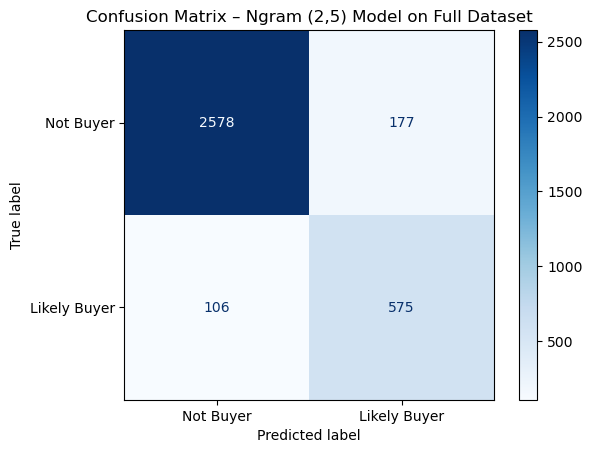

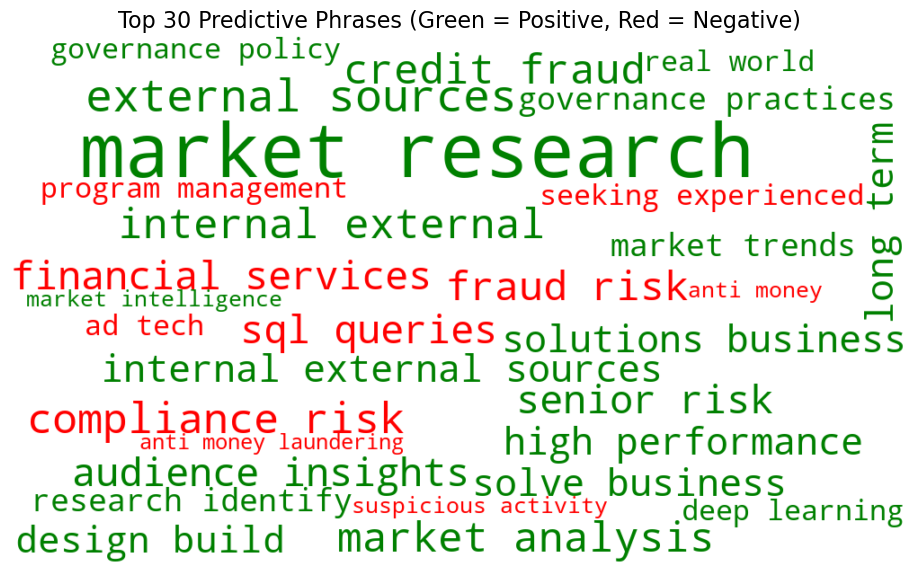

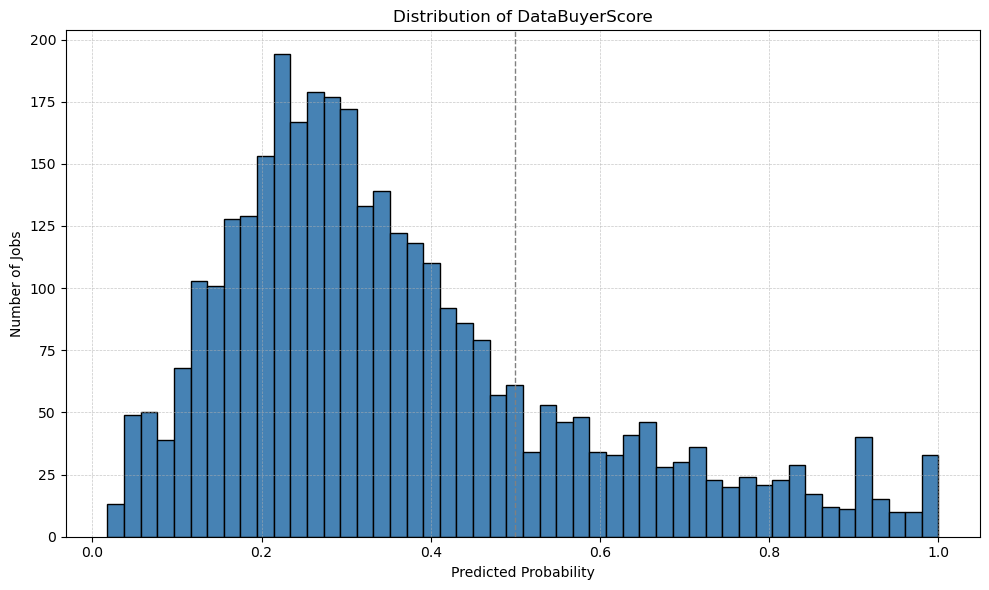

In [5]:
# Part 3: Model training (ngram model - 2,5)

custom_stop_additions= [
    "job", "role", "team", "company", "position", "work", "opportunity", "salary","range","based","university","employment","equal","leadership"
    "mission", "apply", "offer", "skills", "required", "join", "education","degree","bachelors","masters","based","grant",
    "experience", "environment", "collaboration", "communication","vary","location", "continuing","education","support","physical"
    "salary","range","based","college","accredited","opportunities","equity","internalequity","ability","perform",
    "enthusiastic", "passion", "available", "preferred", "background", "usaa","evolving","strategies","data","benefits","day","description",
    "environment","collaborative","mail","days","week","youâ", "ll","expertise","ts","sci","health","dental","develop","maintain"
]

custom_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_additions))


# 1. Prepare text and structured features
X_text_full = df["job_text"].fillna("")
X_struct_full = df[use_case_cols + ["is_senior"]].astype(int)
y_full = df["is_probable_db"]

# 2. TF-IDF vectorization
vectorizer_full = TfidfVectorizer(
    stop_words=custom_stop_words,
    max_features=5000,
    ngram_range=(2, 5),
    min_df=3,
    max_df=0.85
)
X_text_vec_full = vectorizer_full.fit_transform(X_text_full)

# 3. Combine features
X_full_combined = hstack([X_text_vec_full, X_struct_full.values])

# 4. Apply SMOTE to full dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_full_combined, y_full)

# 5. Fit logistic regression with cross-validation
model_full = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1],
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.3, 0.5],
    scoring='f1',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)
model_full.fit(X_resampled, y_resampled)

# 6. Predict on original full data
y_probs_full = model_full.predict_proba(X_full_combined)[:, 1]
y_pred_full = model_full.predict(X_full_combined)

# 7. Evaluate
print("\n Classification Report (Full Data):")
print(classification_report(y_full, y_pred_full, digits=3))
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.4f}")

# 8. Pseudo R²
ll_model = -log_loss(y_full, y_probs_full, normalize=False)
p_null = y_full.mean()
ll_null = -log_loss(y_full, np.full_like(y_full, p_null, dtype=float), normalize=False)
pseudo_r2 = 1 - (ll_model / ll_null)
print(f"\n McFadden's pseudo R² (Full Data): {pseudo_r2:.4f}")


# 9. Top 30 Predictive Features (absolute coefficient values)
all_feature_names = list(vectorizer_full.get_feature_names_out()) + list(X_struct_full.columns)
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": model_full.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n Top 30 Predictive Features (by absolute coefficient):")
print(coef_df.head(30).to_string(index=False))




from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_full, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Buyer", "Likely Buyer"])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Ngram (2,5) Model on Full Dataset")
plt.grid(False)
plt.show()



from wordcloud import WordCloud

# Step 1: Filter out structured flags and undesired features
coef_dict = dict(zip(all_feature_names, model_full.coef_[0]))

# Step 2: Get top 30 features by absolute coefficient 
top_30 = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:30]
top_30_dict = dict(top_30)

# Step 3: Word frequency and color map
word_freq = {k: abs(v) for k, v in top_30_dict.items()}

def color_func(word, *args, **kwargs):
    coef = top_30_dict.get(word, 0)
    return "green" if coef > 0 else "red"

# Step 4: Generate and plot
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    max_words=30
).generate_from_frequencies(word_freq)

wordcloud = wordcloud.recolor(color_func=color_func)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 30 Predictive Phrases (Green = Positive, Red = Negative)", fontsize=16)
plt.show()



# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_probs_full, bins=50, color="steelblue", edgecolor="black")

# Labels and title
plt.title("Distribution of DataBuyerScore")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Jobs")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Optional vertical line at threshold 0.5
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()




 Classification Report (Full Data):
              precision    recall  f1-score   support

           0      0.942     0.870     0.905      2755
           1      0.599     0.783     0.679       681

    accuracy                          0.853      3436
   macro avg      0.770     0.827     0.792      3436
weighted avg      0.874     0.853     0.860      3436

Accuracy: 0.8530

 McFadden's pseudo R² (Full Data): 0.0179

 Top 8 Positive Predictive Titles:
                      Feature  Coefficient
              market research     6.321698
               analytics risk     2.308074
     financial analyst hybrid     2.106428
              party screening     2.092802
                 senior level     1.925824
       scientist senior level     1.925824
intelligence analytics senior     1.800230
laundering compliance officer     1.739800

 Top 8 Negative Predictive Titles:
              Feature  Coefficient
           fraud risk    -3.207111
anti money laundering    -2.303668
           a

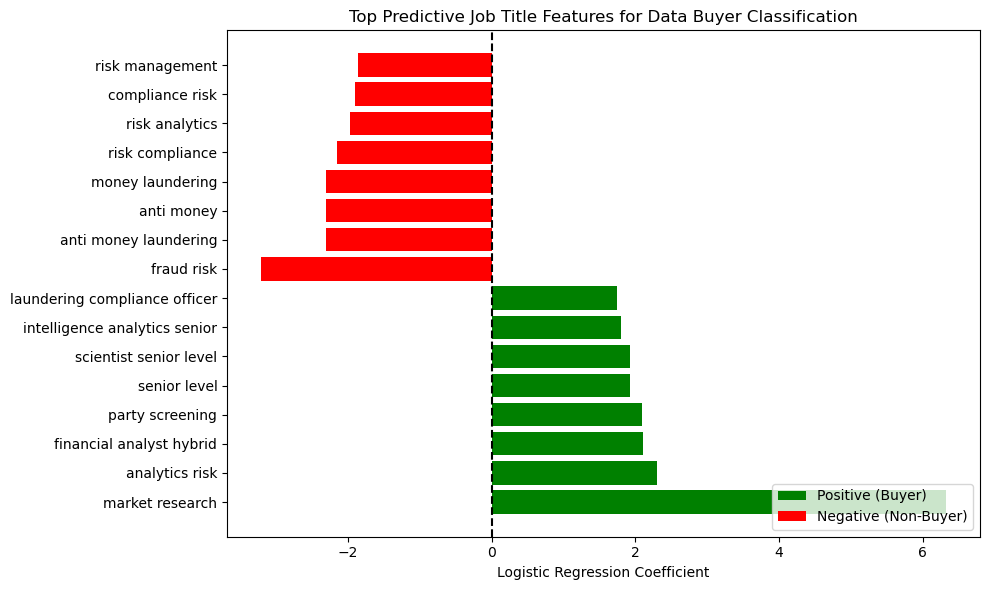

In [7]:
_
# Part 4: Model training with just the Title in the job_text
# 1. Prepare text and structured features
X_text_full = df["title"].fillna("")
X_struct_full = df[use_case_cols + ["is_senior"]].astype(int)
y_full = df["is_probable_db"]

# 2. TF-IDF vectorization
vectorizer_full = TfidfVectorizer(
    stop_words=custom_stop_words,
    max_features=5000,
    ngram_range=(2, 3)
)
X_text_vec_full = vectorizer_full.fit_transform(X_text_full)

# 3. Combine features
X_full_combined = hstack([X_text_vec_full, X_struct_full.values])

# 4. Apply SMOTE to full dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_full_combined, y_full)

# 5. Fit logistic regression with cross-validation
model_full = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1],
    cv=10,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.3, 0.5],
    scoring='f1',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)
model_full.fit(X_resampled, y_resampled)

# 6. Predict on original full data
y_probs_full = model_full.predict_proba(X_full_combined)[:, 1]
y_pred_full = model_full.predict(X_full_combined)

# 7. Evaluate
print("\n Classification Report (Full Data):")
print(classification_report(y_full, y_pred_full, digits=3))
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.4f}")

# 8. Pseudo R²
ll_model = -log_loss(y_full, y_probs_full, normalize=False)
p_null = y_full.mean()
ll_null = -log_loss(y_full, np.full_like(y_full, p_null, dtype=float), normalize=False)
pseudo_r2 = 1 - (ll_model / ll_null)
print(f"\n McFadden's pseudo R² (Full Data): {pseudo_r2:.4f}")

# 9. Extract feature names and coefficients
all_feature_names = list(vectorizer_full.get_feature_names_out()) + list(X_struct_full.columns)
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": model_full.coef_[0]
})

# 10. Filter for title-based features only (exclude structured flags)
title_coef_df = coef_df[~coef_df["Feature"].isin(X_struct_full.columns)]

# 11. Top 10 positive and negative predictors
top_positive = title_coef_df.sort_values("Coefficient", ascending=False).head(8)
top_negative = title_coef_df.sort_values("Coefficient", ascending=True).head(8)

print("\n Top 8 Positive Predictive Titles:")
print(top_positive.to_string(index=False))

print("\n Top 8 Negative Predictive Titles:")
print(top_negative.to_string(index=False))


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_positive["Feature"], top_positive["Coefficient"], color="green", label="Positive (Buyer)")
ax.barh(top_negative["Feature"], top_negative["Coefficient"], color="red", label="Negative (Non-Buyer)")

# Formatting
ax.set_xlabel("Logistic Regression Coefficient")
ax.set_title("Top Predictive Job Title Features for Data Buyer Classification")
ax.axvline(0, color='black', linestyle='--')
ax.legend(loc="lower right")
plt.tight_layout()

# Save the figure
plt.savefig("top_predictive_features.png", dpi=300)
plt.show()

